In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
set(df['sentiment'])

{'negative', 'positive'}

In [7]:
df['target']=df['sentiment'].map({'negative':0,'positive':1})

In [8]:
df.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


<Axes: >

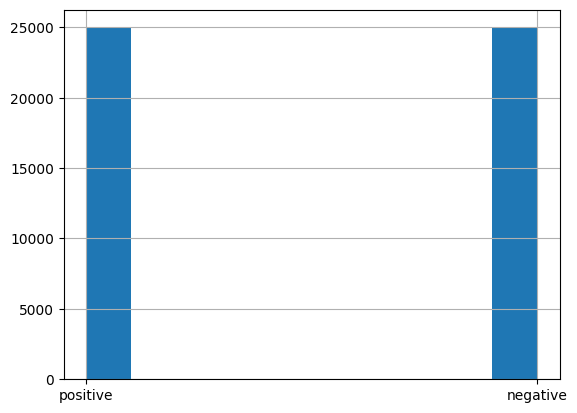

In [9]:
df.sentiment.hist()

In [10]:
df.isnull().sum()

review       0
sentiment    0
target       0
dtype: int64

In [11]:
df.review.count()

50000

In [12]:
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

In [13]:
len(stop)

211

In [14]:
def   clean_text(raw_text):
    # Remove HTML tags
    text_without_html = BeautifulSoup(raw_text, "html.parser").get_text()

    # Remove escape characters and other unwanted symbols
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", "", text_without_html)

    return cleaned_text
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_urls(text):
    # Remove URLs with various formats
    url_pattern = re.compile(r'https?://\S+|www\.\S+|\S+\.\S+')
    return re.sub(url_pattern, '', text)
def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def denoise_text(text) :
    text = clean_text(text)
    text = remove_urls(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [15]:
df['text']=df['review'].apply(denoise_text)

/tmp/ipykernel_26/1161160370.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_without_html = BeautifulSoup(raw_text, "html.parser").get_text()


In [16]:
df.head()

,review,sentiment,target,text
0,One of the other reviewers has mentioned that ...,positive,1,One reviewers mentioned watching 1 Oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,Basically theres family little boy Jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,Petter Matteis Love Time Money visually stunni...


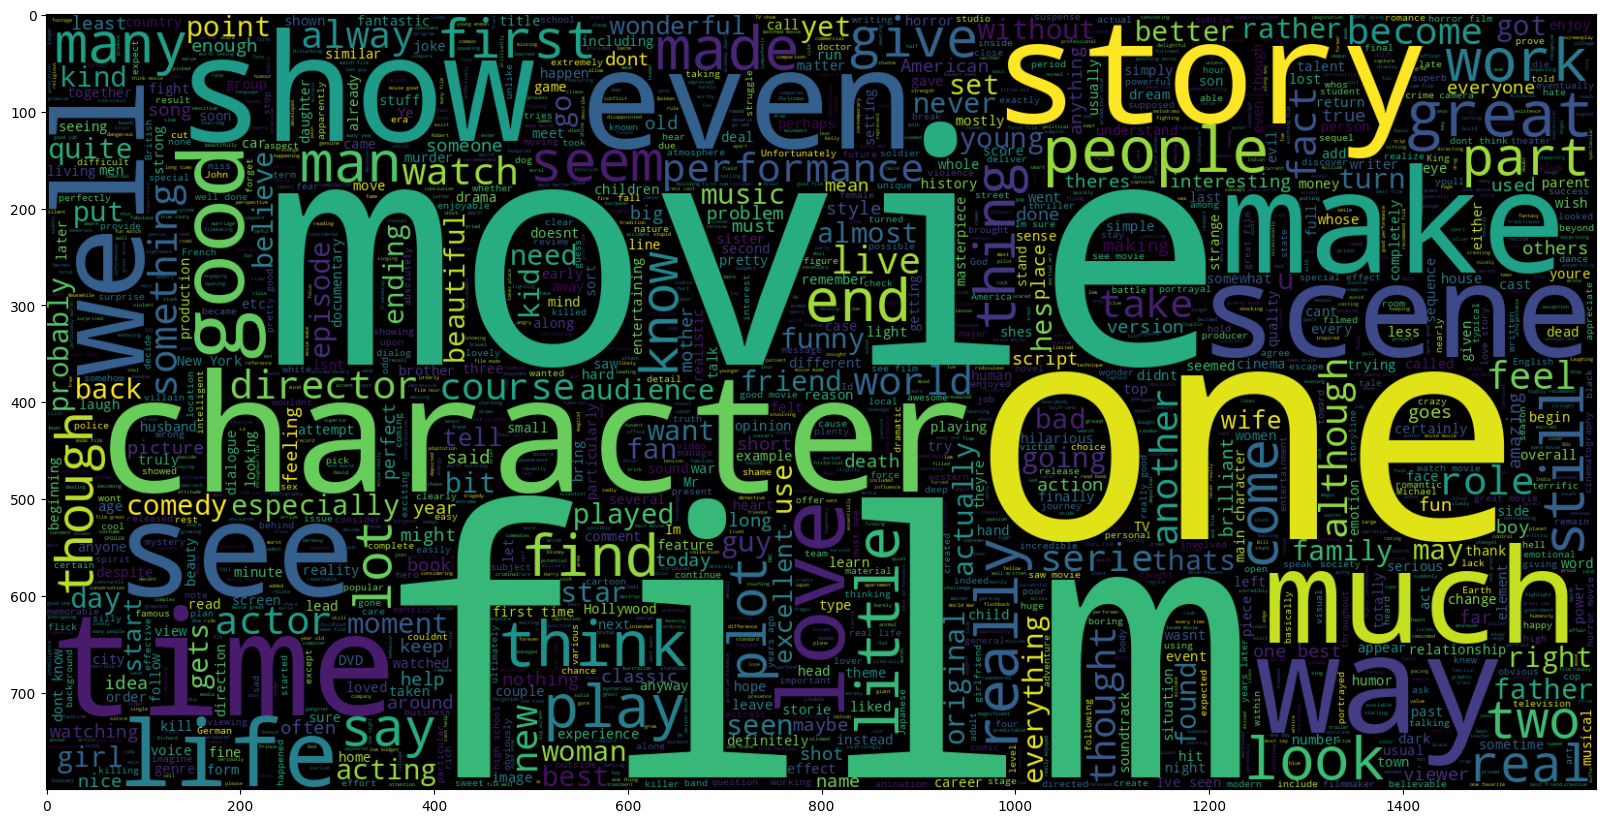

In [17]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000, width= 1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.target==1].text))
plt.imshow(wc, interpolation='bilinear')

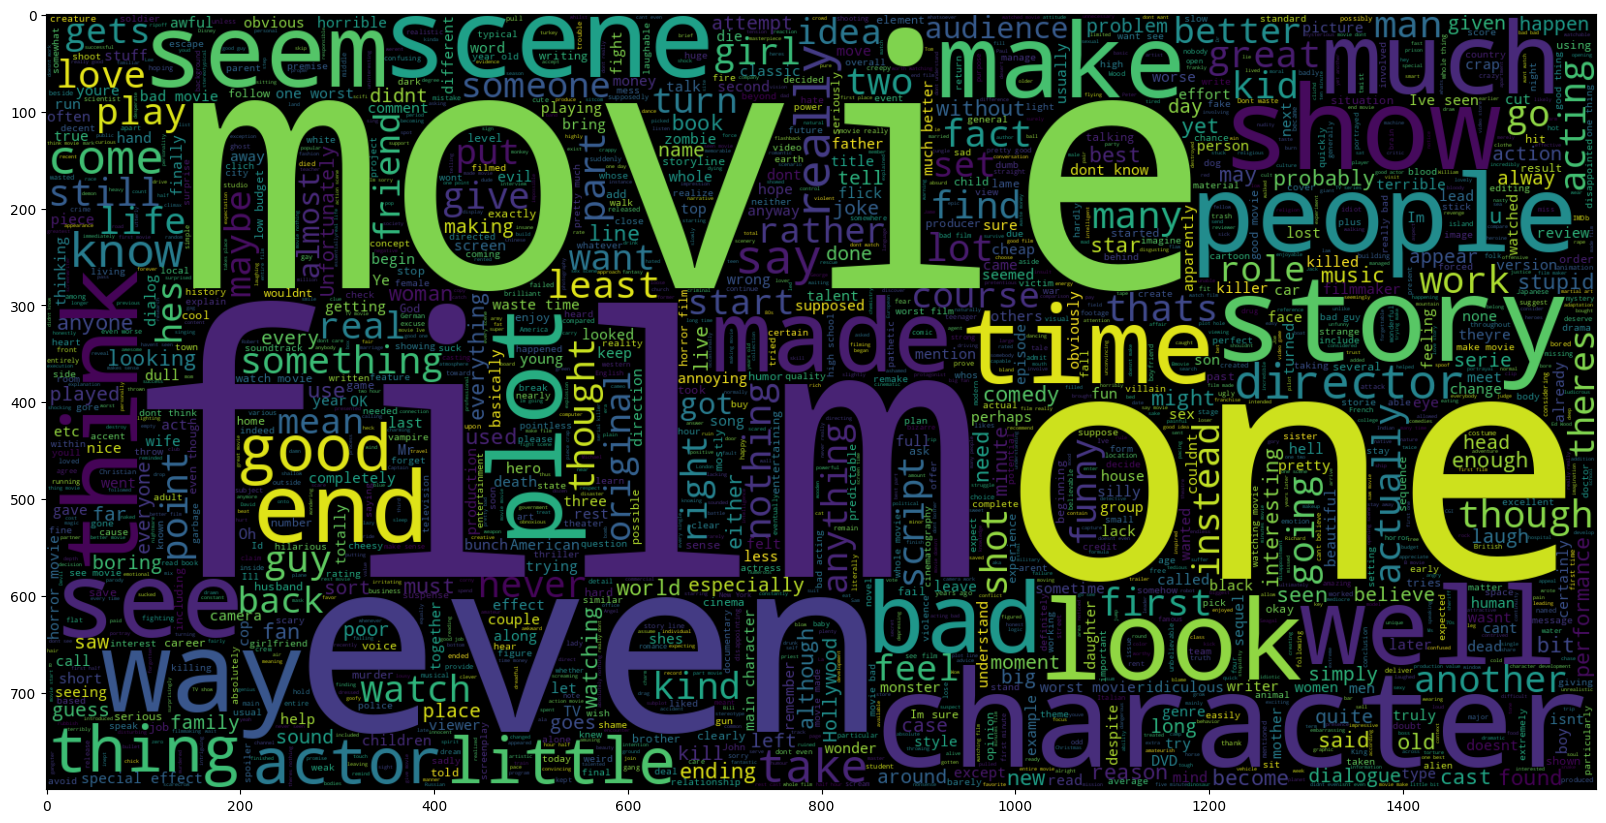

In [18]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000, width= 1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.target==0].text))
plt.imshow(wc, interpolation='bilinear')

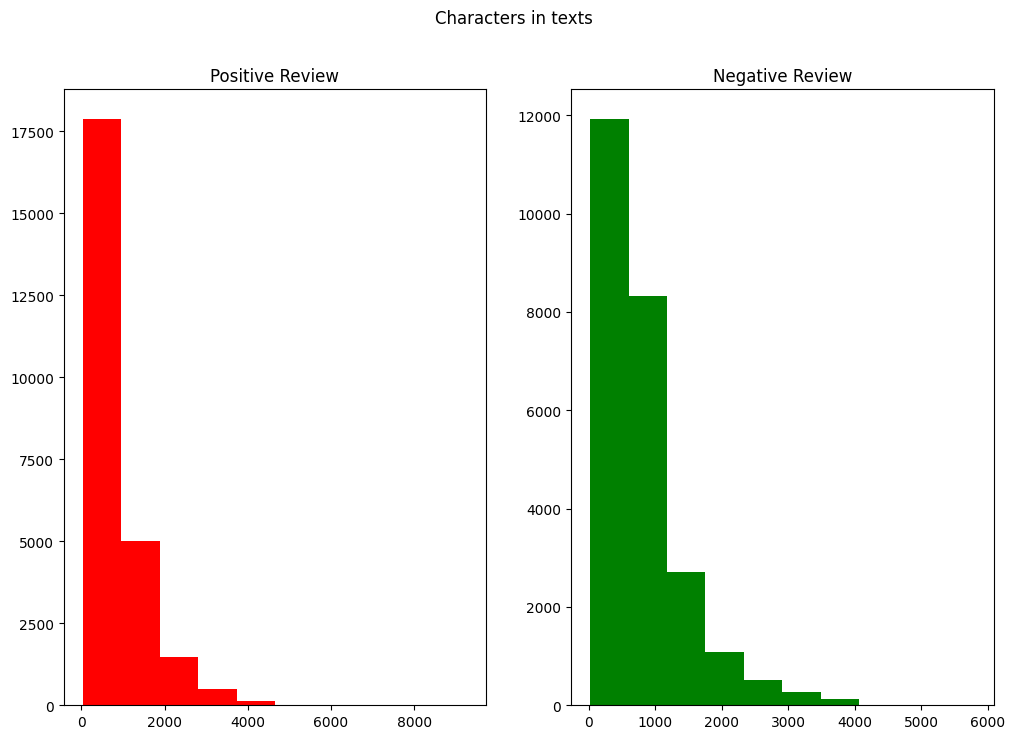

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['target']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Positive Review')
text_len=df[df['target']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Characters in texts')
plt.show()


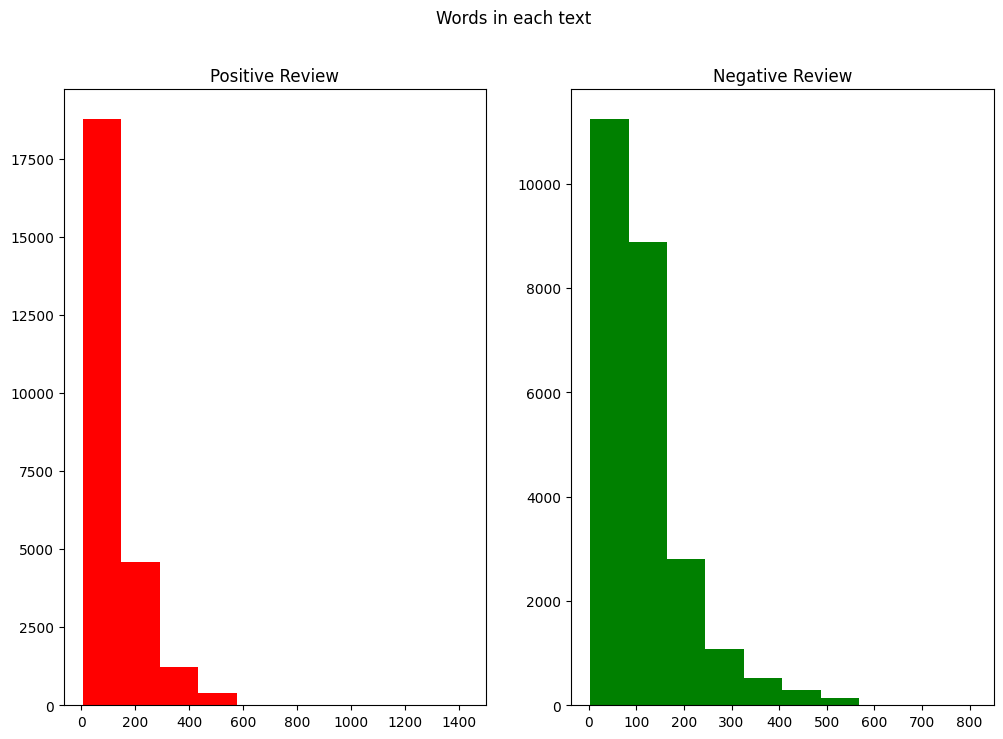

In [20]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(12,8))
word_len=df[df['target']==1]['text'].str.split().map(lambda x:len(x))
ax1.hist(word_len,color='red')
ax1.set_title('Positive Review')
word_len=df[df['target']==0]['text'].str.split().map(lambda x:len(x))
ax2.hist(word_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Words in each text')
plt.show()

/tmp/ipykernel_26/548447746.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_26/548447746.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level f

Text(0.5, 0.98, 'Average word length in each text')

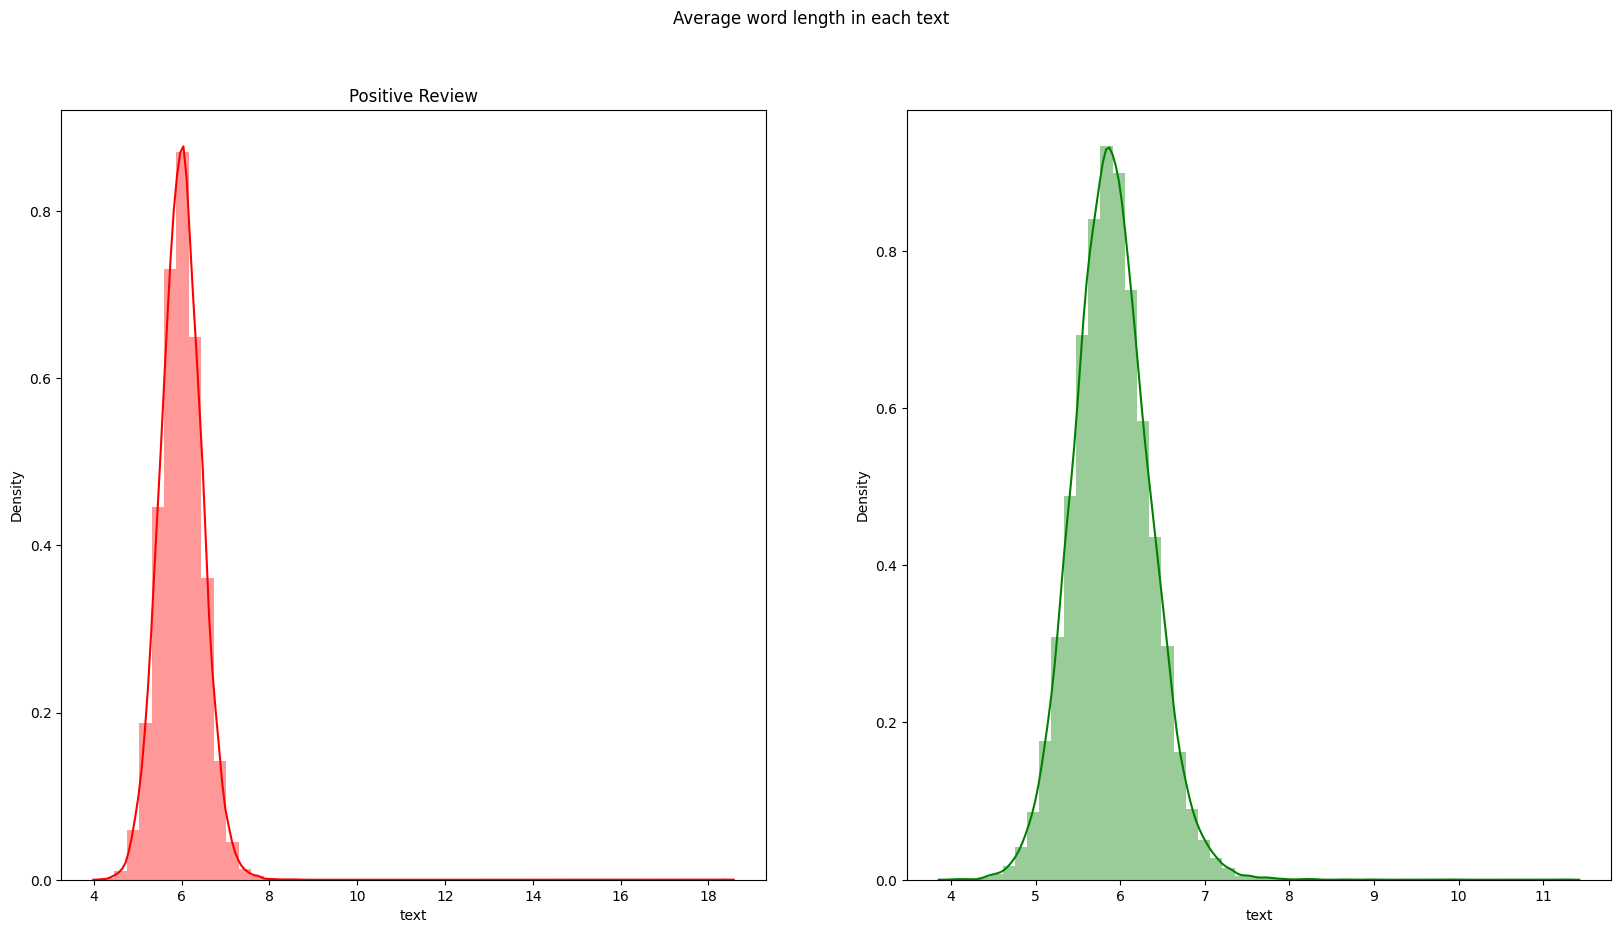

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Positive Review')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax1.set_title('Positive Review')
fig.suptitle('Average word length in each text')

In [22]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['One', 'reviewers', 'mentioned', 'watching', '1']

In [23]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 82315,
 'film': 73516,
 'one': 46304,
 'like': 37485,
 'good': 27403,
 'would': 23753,
 'time': 22744,
 'really': 22207,
 'see': 21766,
 'even': 21496}

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

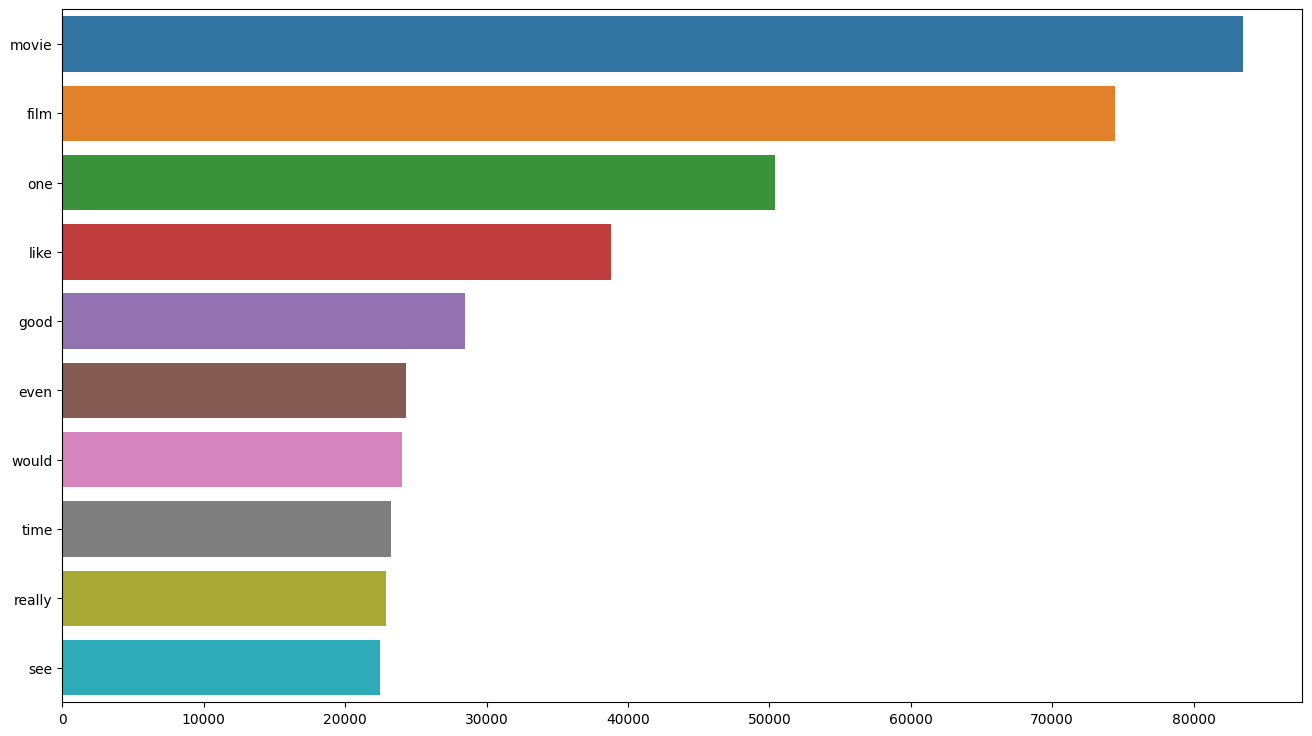

In [25]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

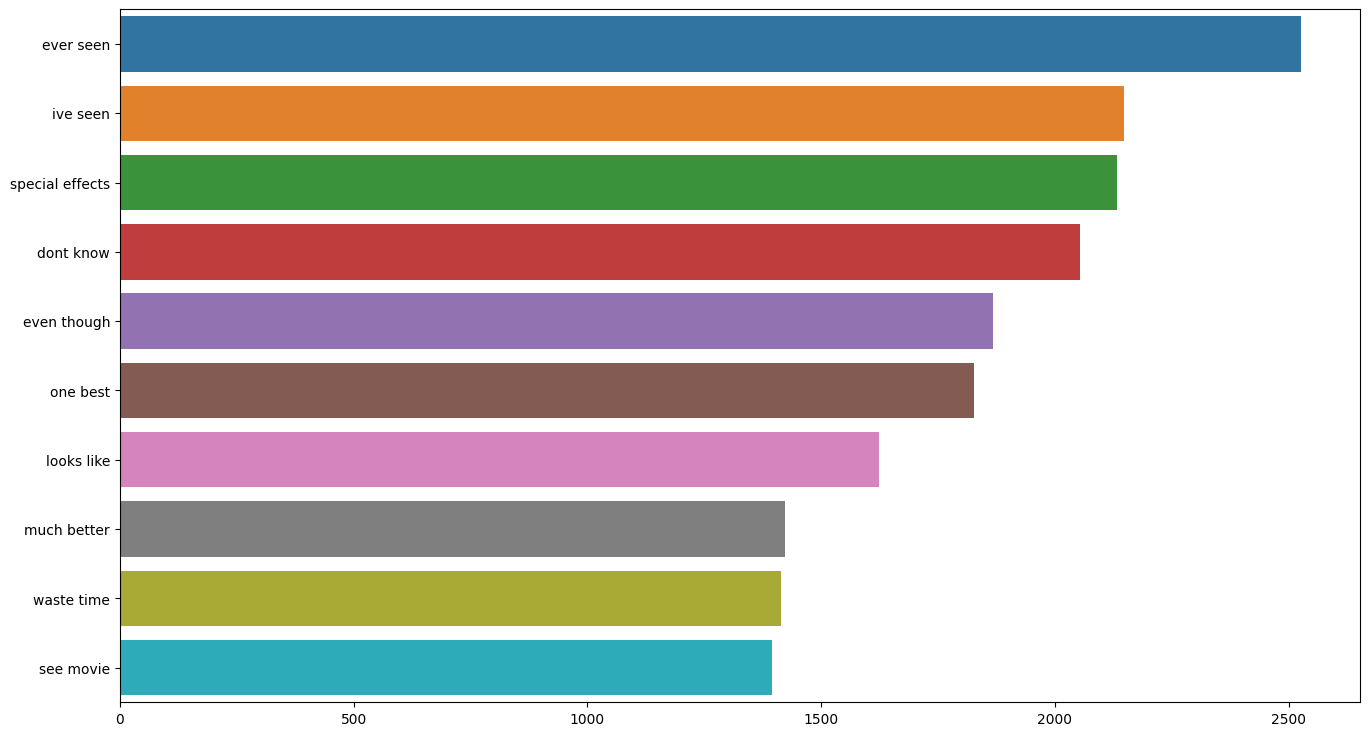

In [26]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

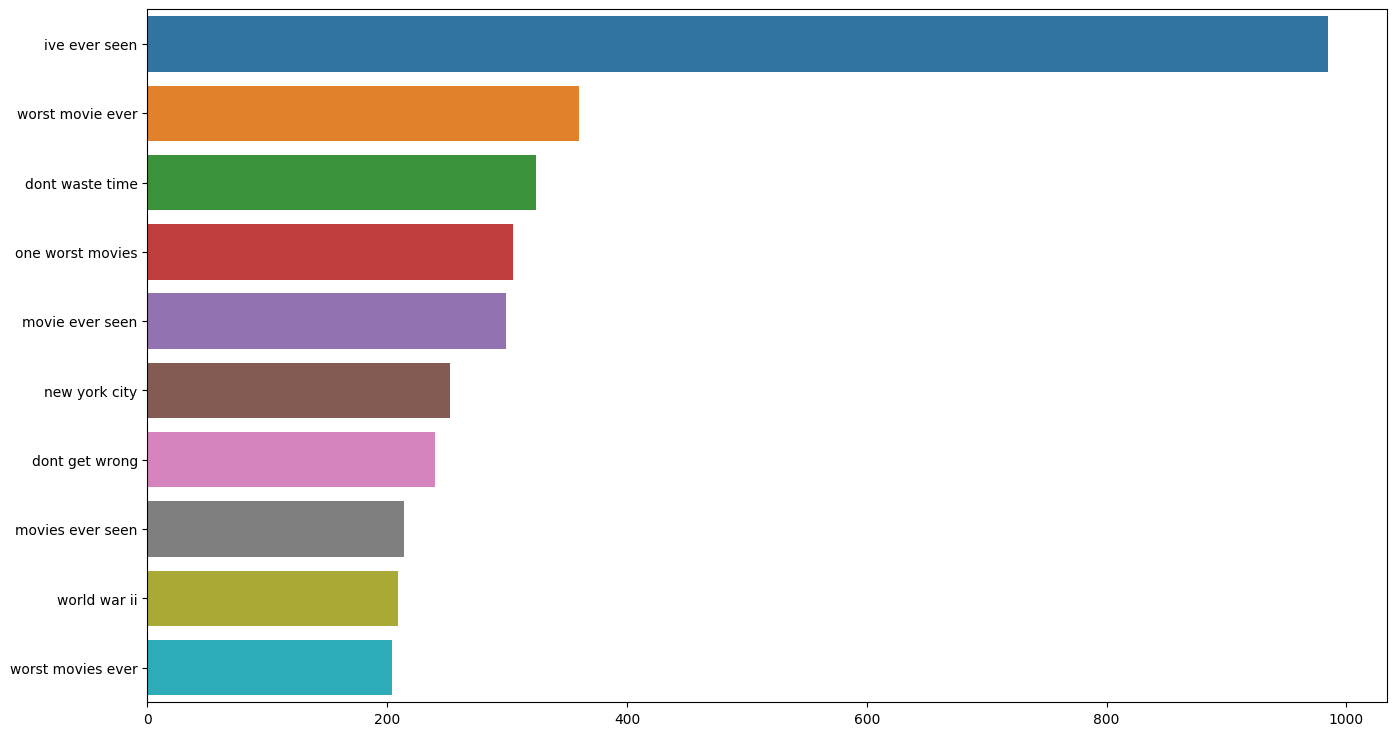

In [27]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [28]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.target,random_state = 0)

In [29]:
max_features = 10000
maxlen = 300

In [30]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [31]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-01-03 17:23:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-03 17:23:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-03 17:23:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [33]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
batch_size = 256
epochs = 10
embed_size = 100

In [35]:
EMBEDDING_FILE = '/kaggle/working/glove.6B.100d.txt'

In [36]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [37]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [39]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
147/147 [==============================] - 285s 2s/step - loss: 0.5155 - accuracy: 0.7463 - val_loss: 0.4291 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 273s 2s/step - loss: 0.4362 - accuracy: 0.8012 - val_loss: 0.4656 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 273s 2s/step - loss: 0.3894 - accuracy: 0.8285 - val_loss: 0.3506 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 273s 2s/step - loss: 0.3548 - accuracy: 0.8447 - val_loss: 0.3444 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 272s 2s/step - loss: 0.3443 - accuracy: 0.8506 - val_loss: 0.3868 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 6/10
147/147 [==============================] - 273s 2s/step - loss: 0.3199 - accuracy: 0.8640 - val_loss: 0.3129 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 7/10
147/147 [==============================] - 273s 2s/st

In [42]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1172/1172 [==============================] - 150s 128ms/step - loss: 0.2776 - accuracy: 0.8848
Accuracy of the model on Training Data is -  88.4773313999176 %
391/391 [==============================] - 50s 127ms/step - loss: 0.3313 - accuracy: 0.8652
Accuracy of the model on Testing Data is -  86.51999831199646 %


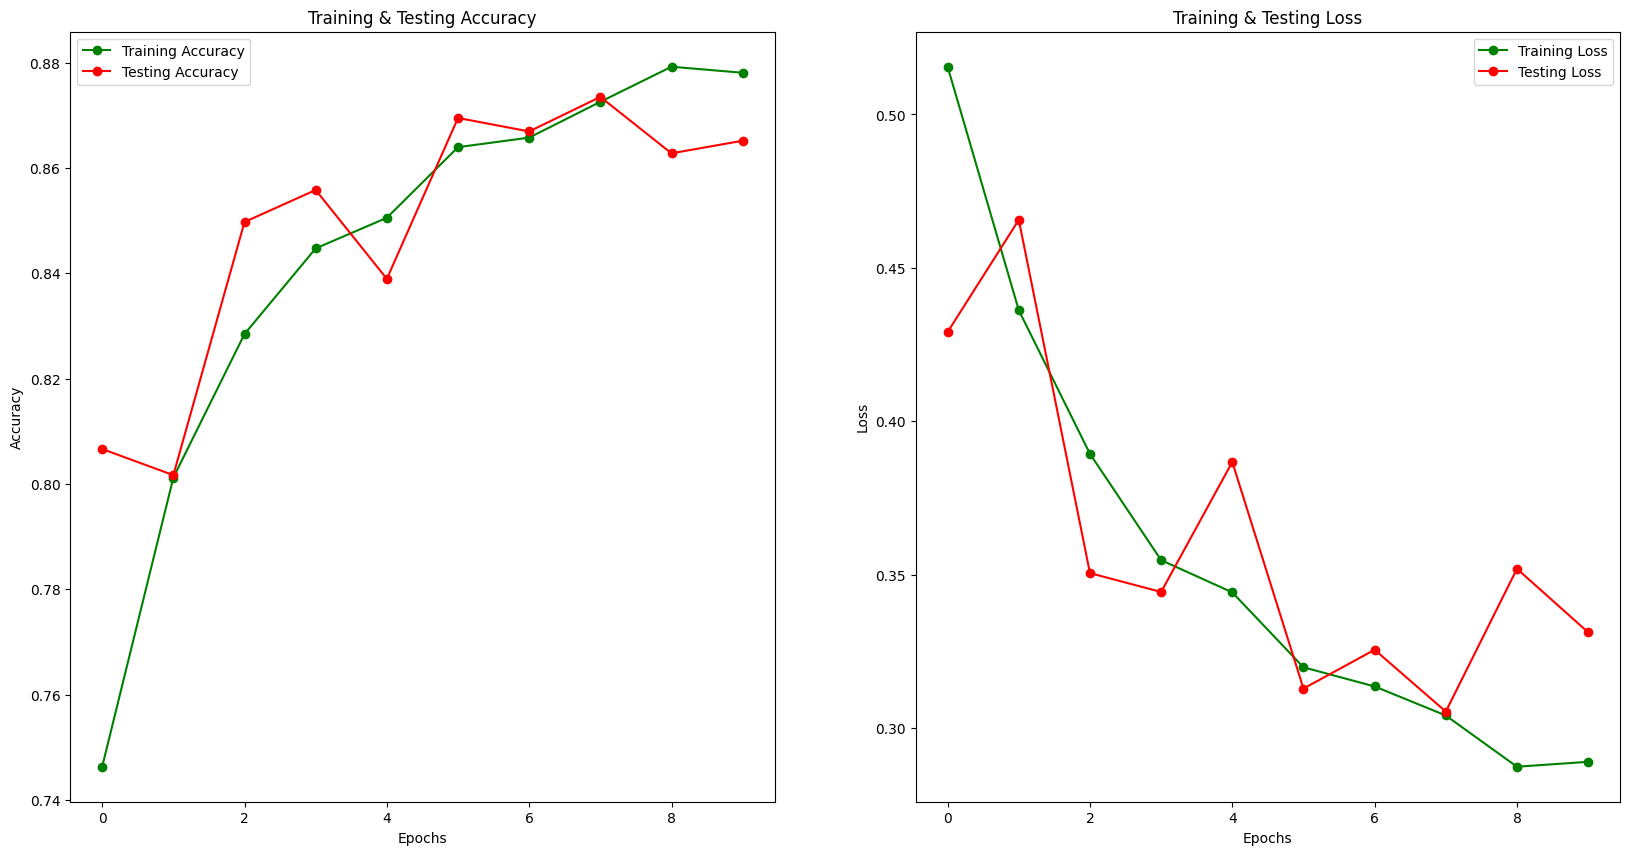

In [43]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [44]:
pred = model.predict(X_test)
pred[:5]

391/391 [==============================] - 50s 127ms/step


array([[0.6440923],
       [0.0048666],
       [0.7491091],
       [0.6815406],
       [0.9932162]], dtype=float32)

In [45]:
pred = (pred > 0.5).astype(int)

In [46]:
pred[:5]

array([[1],
       [0],
       [1],
       [1],
       [1]])

In [47]:
print(classification_report(y_test, pred, target_names = ['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.80      0.86      6291
    Positive       0.82      0.93      0.87      6209

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.86     12500
weighted avg       0.87      0.87      0.86     12500



In [48]:
cm = confusion_matrix(y_test,pred)
cm

array([[5046, 1245],
       [ 440, 5769]])

In [49]:
cm = pd.DataFrame(cm , index = ['Negative','Positive'] , columns =['Negative','Positive'])

Text(95.72222222222221, 0.5, 'Actual')

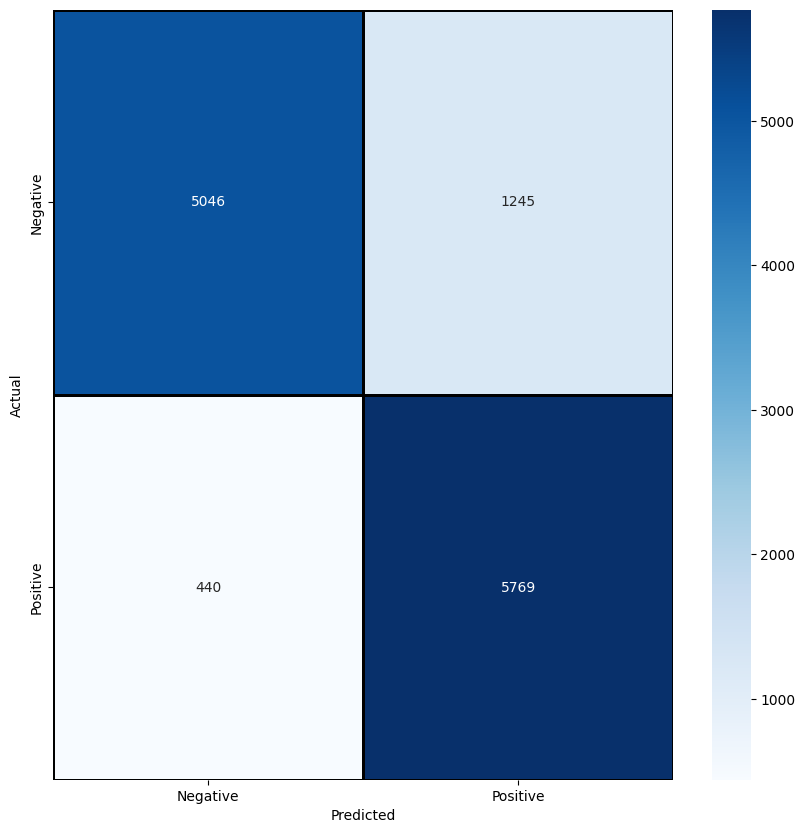

In [50]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative','Positive'] , yticklabels = ['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")